# OLS & Logistic Regression Models for Trading

This notebook demonstrates two fundamental machine learning approaches for trading:
1. **OLS (Ordinary Least Squares) Regression** - Predicting continuous returns
2. **Logistic Regression** - Predicting directional movements

Key topics covered:
- Data preparation and feature engineering
- Model training and prediction
- **Validation strategies** (Train-Test Split, The Random Split Trap, Overfitting)
- Performance metrics for regression and classification
- Backtesting strategies

---

## Setup & Data Import

In [30]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import seaborn as sns

In [31]:
sns.set(style='whitegrid')
mpl.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'svg'

In [32]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv', index_col=0, parse_dates=True)

In [33]:
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


In [34]:
symbol = 'EUR='

In [35]:
data = pd.DataFrame(raw[symbol])

In [36]:
data['returns'] = np.log(data / data.shift(1))

In [37]:
data.dropna(inplace=True)

In [38]:
data['direction'] = np.sign(data['returns']).astype(int)

In [39]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1


<Axes: >

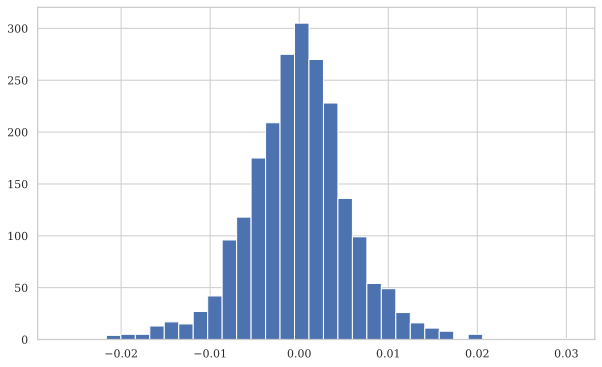

In [40]:
data['returns'].hist(bins=35, figsize=(10,6))

In [41]:
def create_lags(data, lags):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [42]:
create_lags(data, 2)

In [43]:
data.dropna(inplace=True)
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544


---

## Part 1: OLS Regression Models

OLS regression predicts continuous values (returns) based on historical patterns.

### 1.1 OLS Model Training

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
model = LinearRegression()

In [46]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

In [47]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

In [48]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-0.000002,-0.000663
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-0.000164,0.001545
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,0.000030,0.032971
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-0.000245,-0.004227
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-0.000154,-0.061068


In [49]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [50]:
data[['pos_ols_1', 'pos_ols_2']]

,pos_ols_1,pos_ols_2
Date,,
2010-01-06,-1,-1
2010-01-07,-1,1
2010-01-08,1,1
2010-01-11,-1,-1
2010-01-12,-1,-1
...,...,...
2018-06-25,-1,-1
2018-06-26,-1,-1
2018-06-27,1,1


In [51]:
data['pos_ols_1'].value_counts()

pos_ols_1
-1    1863
 1     350
Name: count, dtype: int64

In [52]:
data['pos_ols_2'].value_counts()

pos_ols_2
 1    1310
-1     903
Name: count, dtype: int64

### 1.2 OLS Model Performance Metrics

In [53]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [54]:
# Calculate regression performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For OLS Model 1 (predicting returns)
mse_1 = mean_squared_error(data['returns'], model.predict(data[cols]))
mae_1 = mean_absolute_error(data['returns'], model.predict(data[cols]))
r2_1 = r2_score(data['returns'], model.predict(data[cols]))

print("OLS Model 1 (Predicting Returns):")
print(f"{'='*50}")
print(f"Mean Squared Error (MSE):  {mse_1:.6f}")
print(f"Mean Absolute Error (MAE): {mae_1:.6f}")
print(f"R² Score:                  {r2_1:.6f}")
print(f"\nModel Coefficients: {model.coef_}")
print(f"Model Intercept:    {model.intercept_:.6f}")

OLS Model 1 (Predicting Returns):
Mean Squared Error (MSE):  0.001828
Mean Absolute Error (MAE): 0.032101
R² Score:                  -52.833618

Model Coefficients: [-5.88347472 -4.14545153]
Model Intercept:    0.007147


### 1.3 OLS Backtesting Results

In [55]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.813126
strat_ols_1    0.987177
strat_ols_2    1.287336
dtype: float64

---

## Part 2: Logistic Regression Models

Logistic Regression predicts directional movements (up/down) as a classification problem.

### 2.1 Logistic Regression with Two Binary Features

In [56]:
from sklearn import linear_model

In [57]:
# Create logistic regression model with regularization
model_logreg = linear_model.LogisticRegression(C=1, max_iter=1000)  # C controls overfitting

In [58]:
# Define the create_bins function
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [59]:
# Create binary features from the lag columns
create_bins(data, bins=[0])

In [60]:
# Fit logistic regression model
model_logreg.fit(data[cols_bin], data['direction'])

LogisticRegression(C=1, max_iter=1000)

In [61]:
# Make predictions
data['pos_log_reg'] = model_logreg.predict(data[cols_bin])

### 2.2 Logistic Regression Performance Metrics

In [62]:
# Calculate classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(data['direction'], data['pos_log_reg'])
precision = precision_score(data['direction'], data['pos_log_reg'], average='weighted', zero_division=0)
recall = recall_score(data['direction'], data['pos_log_reg'], average='weighted', zero_division=0)
f1 = f1_score(data['direction'], data['pos_log_reg'], average='weighted', zero_division=0)

print("Logistic Regression Classification Metrics:")
print(f"{'='*50}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(data['direction'], data['pos_log_reg']))

Logistic Regression Classification Metrics:
Accuracy:  0.5178
Precision: 0.5154
Recall:    0.5178
F1 Score:  0.5166

Confusion Matrix:
[[575   0 517]
 [  6   0   5]
 [539   0 571]]


### 2.3 Logistic Regression Backtesting

In [63]:
# Calculate strategy returns
data['strat_log_reg'] = data['pos_log_reg'] * data['returns']

# Compare performance
performance = data[['returns', 'strat_log_reg']].sum().apply(np.exp)
print("Cumulative Performance:")
print(performance)

Cumulative Performance:
returns          0.813126
strat_log_reg    1.385460
dtype: float64


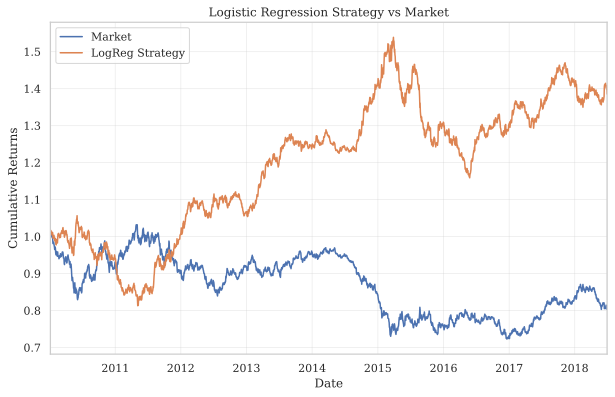

In [64]:
# Plot cumulative returns
data[['returns', 'strat_log_reg']].cumsum().apply(np.exp).plot(figsize=(10,6))
plt.title('Logistic Regression Strategy vs Market')
plt.ylabel('Cumulative Returns')
plt.legend(['Market', 'LogReg Strategy'])
plt.grid(True, alpha=0.3)

In [65]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,lag_1_bin,lag_2_bin,pos_log_reg,strat_log_reg
Date,,,,,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058,0,1,1,0.003058
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544,1,0,-1,0.006544
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,0,1,1,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,1,0,-1,-0.006984
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,1,1,-1,0.001310


### 2.4 Extended Features - Five Lags

In [66]:
data = pd.DataFrame(raw[symbol])

In [67]:
data['returns'] = np.log(data /data.shift(1))

In [68]:
data['direction'] = np.sign(data['returns'])

In [69]:
lags = 5
create_lags(data, 5)

In [70]:
data.dropna(inplace=True)

In [71]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-11,1.4513,0.006984,1.0,0.006544,-0.006544,0.003058,-0.002988,0.006125
2010-01-12,1.4494,-0.001310,-1.0,0.006984,0.006544,-0.006544,0.003058,-0.002988
2010-01-13,1.4510,0.001103,1.0,-0.001310,0.006984,0.006544,-0.006544,0.003058
2010-01-14,1.4502,-0.000551,-1.0,0.001103,-0.001310,0.006984,0.006544,-0.006544
2010-01-15,1.4382,-0.008309,-1.0,-0.000551,0.001103,-0.001310,0.006984,0.006544


In [73]:
# Create binary features for 5 lags
create_bins(data, bins=[0])

In [74]:
# Fit model with 5 lags
model_logreg_5 = linear_model.LogisticRegression(C=1, max_iter=1000)
model_logreg_5.fit(data[cols_bin], data['direction'])

LogisticRegression(C=1, max_iter=1000)

In [75]:
# Predict and backtest
data['pos_log_reg_5'] = model_logreg_5.predict(data[cols_bin])
data['strat_log_reg_5'] = data['pos_log_reg_5'] * data['returns']

In [76]:
data[['returns', 'strat_log_reg_5']].sum().apply(np.exp)

returns            0.810644
strat_log_reg_5    1.191997
dtype: float64

<Axes: xlabel='Date'>

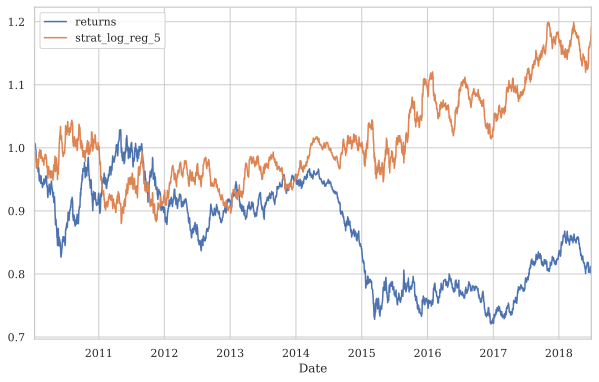

In [77]:
data[['returns', 'strat_log_reg_5']].cumsum().apply(np.exp).plot(figsize=(10,6))

### 2.5 Five Digitized Features (Advanced Binning)

In [78]:
mu = data['returns'].mean()

In [79]:
v = data['returns'].std()

In [80]:
# Binary: bins=[0]
bins = [mu - v, mu, mu + v]

In [81]:
bins

[-0.005924269398870447, -9.498932088272977e-05, 0.0057342907571049885]

In [82]:
create_bins(data, bins)

In [83]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3


In [84]:
# Fit model with digitized features
model_logreg_dig = linear_model.LogisticRegression(C=1, max_iter=1000)
model_logreg_dig.fit(data[cols_bin], data['direction'])

# Predict and backtest
data['pos_log_reg_dig'] = model_logreg_dig.predict(data[cols_bin])
data['strat_log_reg_dig'] = data['pos_log_reg_dig'] * data['returns']

In [85]:
data[['returns', 'strat_log_reg_dig']].sum().apply(np.exp)

returns              0.810644
strat_log_reg_dig    1.483957
dtype: float64

<Axes: xlabel='Date'>

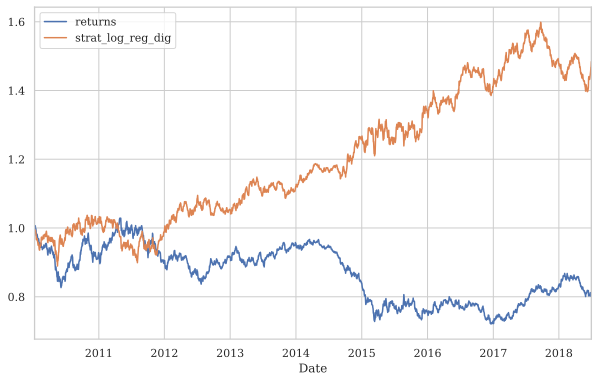

In [86]:
data[['returns', 'strat_log_reg_dig']].cumsum().apply(np.exp).plot(figsize=(10,6))

---

## Part 3: Validation - Train-Test Split in Finance

**Critical concept:** Proper validation is essential to avoid overfitting and ensure model generalizability.

### 3.1 Understanding Overfitting (The Silent Killer)

**Overfitting** occurs when a model learns the training data too well, including its noise and peculiarities, resulting in poor performance on new, unseen data.

**Signs of Overfitting:**
- High accuracy on training data, but poor on test data
- Model is too complex relative to the amount of training data
- Model memorizes rather than generalizes patterns

**In Trading:**
- A model that perfectly predicts past price movements but fails in live trading
- Strategy works great in backtest but loses money in production
- Model captures market noise instead of true signals

In [87]:
# Demonstration of overfitting
from sklearn.metrics import accuracy_score

# Train on full dataset (overfitting risk!)
train_accuracy = accuracy_score(data['direction'], data['pos_log_reg_dig'])
print(f"Training Accuracy (Full Data): {train_accuracy:.4f}")
print("\n⚠️  WARNING: This is NOT a reliable measure!")
print("Model has seen all the data - it's like taking an exam")
print("with all the answers already known.")

Training Accuracy (Full Data): 0.5208

⚠️  WARNING: This is NOT a reliable measure!
Model has seen all the data - it's like taking an exam
with all the answers already known.


### 3.2 The Random Split Trap in Finance

**Why Random Split Fails in Finance:**

In traditional ML (e.g., image classification), random splitting is acceptable because:
- Data points are independent
- No temporal relationship between samples

**But in finance:**
- Data points are **NOT independent** - they follow a time series
- Future prices depend on past prices (autocorrelation)
- **Look-ahead bias**: Random split can put future data in training set and past data in test set
- This creates unrealistic "time travel" scenarios

**The Trap:**
```python
# ❌ WRONG: Random split
train_test_split(data, shuffle=True)  # Mixes past and future!
```

This allows the model to "cheat" by learning from the future to predict the past!

### 3.3 Chronological (Sequential) Split - The Correct Way

**The Right Approach:**
- Train on historical data (e.g., first 70%)
- Test on future data (e.g., last 30%)
- Maintains temporal order
- Simulates real trading: learn from past, predict future

**Benefits:**
- No look-ahead bias
- Realistic performance estimates
- Respects time-series nature of financial data
- Similar to walk-forward analysis

#### 3.3.1 Implementation - Sequential Split

In [90]:
split = int(len(data) * 0.5)

In [91]:
train = data.iloc[:split].copy()

In [92]:
test = data.iloc[split:].copy()

print(f"Sequential Split Analysis")
print(f"{'='*60}")
print(f"Training Period: {train.index[0]} to {train.index[-1]}")
print(f"Testing Period:  {test.index[0]} to {test.index[-1]}")
print(f"\nTraining samples: {len(train)}")
print(f"Testing samples:  {len(test)}")
print(f"\n✓ No temporal overlap - this is correct!")

Sequential Split Analysis
Training Period: 2010-01-11 00:00:00 to 2014-04-04 00:00:00
Testing Period:  2014-04-07 00:00:00 to 2018-06-29 00:00:00

Training samples: 1105
Testing samples:  1105

✓ No temporal overlap - this is correct!


In [93]:
# Train logistic regression model on training data only
model_seq = linear_model.LogisticRegression(C=1, max_iter=1000)
model_seq.fit(train[cols_bin], train['direction'])

LogisticRegression(C=1, max_iter=1000)

In [94]:
# Predict on test data (unseen future data)
test['pos_log_reg'] = model_seq.predict(test[cols_bin])
test['strat_log_reg'] = test['pos_log_reg'] * test['returns']

# Evaluate train vs test performance
train_acc = accuracy_score(train['direction'], model_seq.predict(train[cols_bin]))
test_acc = accuracy_score(test['direction'], test['pos_log_reg'])

print(f"\nModel Performance:")
print(f"{'='*60}")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Performance Gap:   {(train_acc - test_acc):.4f}")
print(f"\n{'⚠️  Large gap suggests overfitting!' if (train_acc - test_acc) > 0.05 else '✓ Reasonable generalization'}")


Model Performance:
Training Accuracy: 0.5240
Testing Accuracy:  0.4986
Performance Gap:   0.0253

✓ Reasonable generalization


In [95]:
test[['returns', 'strat_log_reg']].sum().apply(np.exp)

returns          0.852649
strat_log_reg    1.077934
dtype: float64

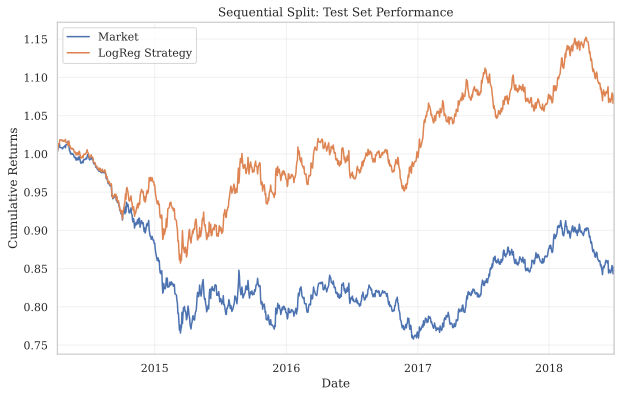

In [96]:
test[['returns', 'strat_log_reg']].cumsum().apply(np.exp).plot(figsize=(10,6))
plt.title('Sequential Split: Test Set Performance')
plt.ylabel('Cumulative Returns')
plt.legend(['Market', 'LogReg Strategy'])
plt.grid(True, alpha=0.3)

### 3.4 Random Split - Demonstrating the Trap

**⚠️ This section demonstrates WHY random split is problematic in finance.**

We'll show how random splitting can give misleadingly good results due to look-ahead bias.

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
train, test = train_test_split(data, test_size=0.5, shuffle=True, random_state=100)

In [99]:
train = train.copy().sort_index()

In [100]:
print("Random Split Visualization:")
print(f"{'='*60}")
print(f"Training period: {train.index[0]} to {train.index[-1]}")
print(f"Testing period:  {test.index[0]} to {test.index[-1]}")
print(f"\n⚠️  PROBLEM: Training and test data are temporally mixed!")
print("Train and test sets contain data from overlapping time periods.")
print("This creates look-ahead bias - the model 'sees the future'!")

Random Split Visualization:
Training period: 2010-01-11 00:00:00 to 2018-06-27 00:00:00
Testing period:  2014-02-19 00:00:00 to 2010-06-30 00:00:00

⚠️  PROBLEM: Training and test data are temporally mixed!
Train and test sets contain data from overlapping time periods.
This creates look-ahead bias - the model 'sees the future'!


In [101]:
train[cols_bin].head(10)

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-18,0,1,2,1,3
2010-01-19,2,0,1,2,1
2010-01-20,0,2,0,1,2
2010-01-26,2,2,1,0,0
2010-01-28,1,1,2,2,1


In [102]:
test = test.copy().sort_index()

In [103]:
# Train model with random split
model_rand = linear_model.LogisticRegression(C=1, max_iter=1000)
model_rand.fit(train[cols_bin], train['direction'])

LogisticRegression(C=1, max_iter=1000)

In [104]:
# Test performance
test['pos_log_reg_rand'] = model_rand.predict(test[cols_bin])
test['strat_log_reg_rand'] = test['pos_log_reg_rand'] * test['returns']

# Compare accuracies
train_acc_rand = accuracy_score(train['direction'], model_rand.predict(train[cols_bin]))
test_acc_rand = accuracy_score(test['direction'], test['pos_log_reg_rand'])

print(f"\nRandom Split Performance:")
print(f"{'='*60}")
print(f"Training Accuracy: {train_acc_rand:.4f}")
print(f"Testing Accuracy:  {test_acc_rand:.4f}")
print(f"Performance Gap:   {(train_acc_rand - test_acc_rand):.4f}")
print(f"\n⚠️  Results may look artificially good due to look-ahead bias!")
print("In real trading, you would NEVER have this information.")


Random Split Performance:
Training Accuracy: 0.5376
Testing Accuracy:  0.4923
Performance Gap:   0.0452

⚠️  Results may look artificially good due to look-ahead bias!
In real trading, you would NEVER have this information.


In [105]:
test[['returns', 'strat_log_reg_rand']].sum().apply(np.exp)

returns               0.736500
strat_log_reg_rand    0.788983
dtype: float64

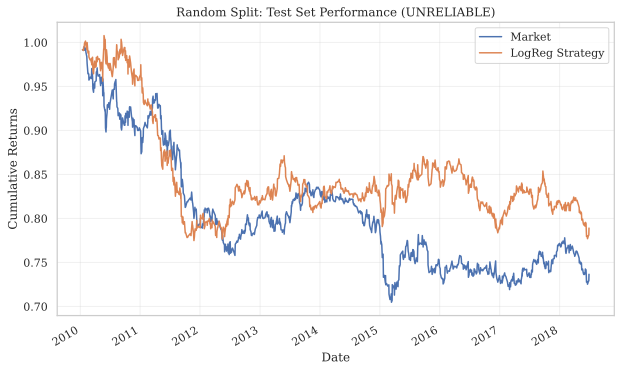

In [106]:
test[['returns', 'strat_log_reg_rand']].cumsum().apply(np.exp).plot(figsize=(10,6))
plt.title('Random Split: Test Set Performance (UNRELIABLE)')
plt.ylabel('Cumulative Returns')
plt.legend(['Market', 'LogReg Strategy'])
plt.grid(True, alpha=0.3)

---

## Appendix: Understanding Binning

Binning (digitization) converts continuous values into discrete categories.

In [107]:
price_change = pd.Series([-0.5, 0.2, 0.0, -1.0, 1.5])

In [108]:
np.digitize(price_change, bins=[0])

array([0, 1, 1, 0, 1])

In [109]:
price_change = pd.Series([-3, -1.5, -0.5, 0., 0.5, 1.5, 3])

In [110]:
bins = [-2, -1, 0, 1, 2]

In [111]:
binned_data = np.digitize(price_change, bins=bins)

In [112]:
pd.DataFrame({'price_change': price_change, 'binned_data': binned_data})

,price_change,binned_data
0,-3.0,0
1,-1.5,1
2,-0.5,2
3,0.0,3
4,0.5,3
5,1.5,4
6,3.0,5


---

## Summary: Key Takeaways

### Models Covered:
1. **OLS Regression** - Predicts continuous returns
   - Metrics: MSE, MAE, R²
   - Best for: Forecasting actual price movements
   
2. **Logistic Regression** - Predicts directional movements
   - Metrics: Accuracy, Precision, Recall, F1, Confusion Matrix
   - Best for: Binary up/down predictions

### Validation Critical Points:

✅ **DO:**
- Use chronological (sequential) split for time-series data
- Train on past, test on future
- Check train vs test performance gap
- Monitor for overfitting

❌ **DON'T:**
- Use random split for financial data
- Train on full dataset without validation
- Ignore look-ahead bias
- Trust results that seem "too good"

### Performance Metrics:

**Regression (OLS):**
- Mean Squared Error (MSE) - penalizes large errors
- Mean Absolute Error (MAE) - average prediction error
- R² Score - proportion of variance explained

**Classification (LogReg):**
- Accuracy - overall correct predictions
- Precision - correct positive predictions / all positive predictions
- Recall - correct positive predictions / all actual positives
- F1 Score - harmonic mean of precision and recall
- Confusion Matrix - detailed breakdown of predictions

### The Silent Killer: Overfitting
- Always validate on unseen data
- Large train/test performance gap = overfitting
- In finance, overfitting leads to losses in live trading

---

## 📝 Student Assignment

Complete the following tasks to apply what you've learned about OLS and Logistic Regression models for trading.

**Expected Time**: 90-120 minutes

---

## Task 1: Chronological Train-Test Split & Model Comparison

**Objective:** Build and validate both OLS and Logistic Regression models using proper time-series validation.

Follow the complete workflow to compare model performance on a new asset.

In [ ]:
# TODO: Step 1 - Explore available symbols and select one
# Hint: Use print(raw.columns.tolist()) to see all available symbols
# Then choose a different symbol from the dataset (e.g., 'GDX', '.SPX', 'AAPL.O')

symbol_choice = 'GDX'  # Replace with your chosen symbol

In [ ]:
# TODO: Step 2 - Prepare the data
# 1. Create a new DataFrame for your chosen symbol
# 2. Calculate log returns
# 3. Create direction labels (1 for up, -1 for down)
# 4. Create 3 lagged features using the create_lags() function
# 5. Drop any missing values
# 6. Display the first few rows to verify

# Your code here

In [ ]:
# TODO: Step 3 - Split the data chronologically (80% train, 20% test)
# 1. Calculate the split point (80% of data length)
# 2. Create train and test sets using iloc
# 3. Print split information (periods, sample counts)
# Remember: Use .copy() to avoid warnings!

# Your code here

### Step 4A: Train and Evaluate OLS Regression Model

In [ ]:
# TODO: Train OLS model and make predictions
# 1. Create LinearRegression model and fit on training data
# 2. Make predictions on both train and test sets
# 3. Convert predictions to positions (1 for long, -1 for short)
# 4. Calculate strategy returns
# Hint: Use the 'cols' variable that was created by create_lags()

# Your code here

In [ ]:
# TODO: Calculate OLS performance metrics
# Calculate for both train and test sets:
# - Mean Squared Error (MSE)
# - R² Score
# - Directional Accuracy (compare predictions vs actual direction)
# Print a formatted comparison table
# Check for overfitting by comparing train vs test performance

# Your code here

### Step 4B: Train and Evaluate Logistic Regression Model

In [ ]:
# TODO: Train Logistic Regression model
# 1. Create binary features using create_bins() with bins=[0]
# 2. Train LogisticRegression model on training data
# 3. Make predictions on both train and test sets
# 4. Calculate strategy returns
# Hint: Use cols_bin variable created by create_bins()

# Your code here

In [ ]:
# TODO: Calculate Logistic Regression performance metrics
# Calculate for both train and test sets:
# - Accuracy
# - Precision
# - F1 Score
# Print a formatted comparison table
# Check for overfitting by comparing train vs test performance

# Your code here

### Step 5: Visualize Cumulative Returns

In [ ]:
# TODO: Visualize cumulative returns
# 1. Combine train and test data
# 2. Plot cumulative returns for: market, OLS strategy, LogReg strategy
# 3. Add vertical line to mark train/test split point
# 4. Customize with title, labels, and legend
# Hint: Use .cumsum().apply(np.exp) to get cumulative returns

# Your code here

### Analysis Questions for Task 1

Answer the following questions based on your results:

**TODO: Write your analysis here**

1. **Which model performs better on the test set?**
   - Compare test accuracy and cumulative returns
   - Consider both absolute performance and consistency

2. **Do you see signs of overfitting?**
   - Compare train vs test performance gap
   - Is there a significant drop in accuracy on test data?
   - What does this tell you about model generalization?

3. **How does your chosen asset compare to the EUR= example?**
   - Are both models profitable on your asset?
   - Is the market regime different (trending vs mean-reverting)?
   - What insights can you draw from the differences?

---

## Task 2: Feature Engineering Exploration

**Objective:** Experiment with different feature configurations to improve model performance.

**Choose ONE of the following options to implement:**

### Option A: Lag Window Experiment

Test different numbers of lags (2, 3, 5, 7, 10) to find the optimal feature window.

In [ ]:
# TODO: Define a function to test different lag configurations
def test_lag_configuration(symbol, lag_count, train_size=0.8):
    """
    Test logistic regression model with different number of lags
    
    Parameters:
    -----------
    symbol : str
        The symbol to test
    lag_count : int
        Number of lags to create
    train_size : float
        Proportion of data for training (default: 0.8)
    
    Returns:
    --------
    dict : Dictionary containing performance metrics
        - lags: number of lags used
        - train_accuracy: training accuracy
        - test_accuracy: testing accuracy
        - test_returns: cumulative test returns
        - overfitting: boolean indicating if overfitting detected
    """
    # Your implementation here
    # Steps: prepare data, create lags, create bins, split, train, evaluate
    
    return {
        'lags': lag_count,
        'train_accuracy': None,
        'test_accuracy': None,
        'test_returns': None,
        'overfitting': None
    }

In [ ]:
# TODO: Test multiple lag configurations
# Test lag_options = [2, 3, 5, 7, 10]
# Collect results in a list, then create a DataFrame
# Optional: Style the table for better readability

# Your code here

**Analysis Questions for Option A:**

**TODO: Write your analysis here**

1. Which lag configuration gives the best test performance? Why?
2. Do more lags always help? What do you observe?
3. At what point does adding more lags lead to overfitting?
4. What is the trade-off between model complexity and generalization?

---

### Option B: Additional Technical Indicators

Add new technical features to improve predictions beyond simple lagged returns.

In [ ]:
# TODO: Prepare baseline data and add technical indicators
# 1. Create baseline data with returns, direction, and lags
# 2. Choose and add at least ONE technical indicator:
#    - Option 1: Moving Average (MA) crossover signal
#    - Option 2: Rolling Volatility (normalized)
#    - Option 3: Momentum indicator (rate of change)
# 3. Drop NaN values
# 4. Display data to verify

# Your code here

In [ ]:
# TODO: Train baseline model WITHOUT new features
# 1. Split data chronologically
# 2. Create binary features with create_bins()
# 3. Train LogisticRegression on ONLY the lag features
# 4. Calculate test accuracy and returns
# 5. Print baseline performance

# Your code here

In [ ]:
# TODO: Train enhanced model WITH new features
# 1. Define extended feature list (lag features + your new indicators)
# 2. Train LogisticRegression on expanded feature set
# 3. Calculate test accuracy and returns
# 4. Compare with baseline performance
# 5. Print improvement metrics

# Your code here

**Analysis Questions for Option B:**

**TODO: Write your analysis here**

1. Did the new features improve test performance? By how much?
2. Which technical indicator(s) did you add and why?
3. Why might these features help (or not help) the model?
4. Did adding features lead to any overfitting? How can you tell?

---

### Option C: Advanced Binning Strategy

Experiment with different binning approaches to see how feature discretization affects model performance.

In [ ]:
# TODO: Prepare data for binning experiments
# 1. Create data with returns, direction, and lags
# 2. Calculate mean (mu) and std dev (v) of returns
# 3. Print statistics to understand bin thresholds
# 4. Calculate potential bin edges for different strategies

# Your code here

In [ ]:
# TODO: Define a function to test different binning strategies
def test_binning_strategy(data, bins, strategy_name):
    """
    Test logistic regression with different binning strategy
    
    Parameters:
    -----------
    data : DataFrame
        The data to test
    bins : list
        The bin thresholds to use
    strategy_name : str
        Name of the binning strategy
    
    Returns:
    --------
    dict : Performance metrics including accuracy and returns
    """
    # Your implementation here
    # Steps: copy data, create bins, split, train, evaluate
    
    return {
        'strategy': strategy_name,
        'bins': str(bins),
        'test_accuracy': None,
        'test_returns': None
    }

In [ ]:
# TODO: Compare different binning strategies
# Test three strategies:
# 1. Binary bins: [0]
# 2. Three bins using mean ± std dev: [mu - v, mu, mu + v]
# 3. Quantile bins: [33rd percentile, 67th percentile]
# Collect results and create comparison DataFrame
# Optional: Style the table for better readability

# Your code here

**Analysis Questions for Option C:**

**TODO: Write your analysis here**

1. Which binning strategy works best for your asset?
2. Does the binning choice make a significant difference?
3. Why might one binning strategy outperform others?
4. How does the optimal binning relate to the distribution of returns?

---

## Submission Checklist

Your completed notebook should include:

- [ ] **Task 1 completed** with all code cells uncommented and executed
- [ ] **One option from Task 2** fully implemented and analyzed
- [ ] **At least 2 visualizations** showing cumulative returns
- [ ] **Performance metrics tables** clearly formatted and displayed
- [ ] **Written analysis** (3-5 paragraphs) addressing all analysis questions
- [ ] **Code comments** explaining your implementation choices
- [ ] **Markdown cells** documenting your findings and insights

---

## Final Summary & Reflection

**TODO: Write your comprehensive summary here (3-5 paragraphs)**

Your summary should address:

1. **Main Findings from Task 1:**
   - Which model (OLS vs LogReg) performed better on your chosen asset?
   - What evidence of overfitting did you observe?
   - How did your results compare to the EUR= example in the main notebook?

2. **Insights from Task 2:**
   - What did your feature engineering experiments reveal?
   - Did additional features or different configurations improve performance?
   - What surprised you about the results?

3. **Understanding Model Validation:**
   - Why is chronological splitting crucial for financial data?
   - How would you identify overfitting in your models?
   - What did you learn about the bias-variance tradeoff?

4. **Key Takeaways:**
   - What are the most important lessons from this assignment?
   - How would you approach model validation differently in the future?
   - What questions remain for further exploration?

5. **Ideas for Improvement:**
   - What other features or techniques could improve these models?
   - What are the limitations of these approaches?
   - What would you try next if you continued this work?

---

**Remember:** The goal is understanding the process and learning from experiments, not finding the "perfect" model. Focus on developing intuition about model behavior, overfitting, and proper validation techniques. 🚀